In [1]:
import os

import numpy as np
import wfdb

from biosppy.signals import ecg
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
from pyecharts.charts import Line
from pyecharts import options as opts
from pyecharts.globals import ThemeType

%matplotlib notebook

In [2]:
# Patient candidates. Exclude [102, 104, 107, 217] due to poor quality
PATIENTS = [100, 101, 103, 105, 106, 108, 109,
            111, 112, 113, 114, 115, 116, 117, 118, 119,
            121, 122, 123, 124,
            200, 201, 202, 203, 205, 207, 208, 209,
            210, 212, 213, 214, 215, 219,
            220, 221, 222, 223, 228, 230, 231, 232, 233, 234]
N = {"N", "L", "R"}
S = {"a", "J", "A", "S", "j", "e"}
V = {"V", "E"}
F = {"F"}
Q = {"/", "f", "Q"}

# All beats
BEATS = N.union(S, V, F, Q)
# Anomalous beats
ANOMALOUS_BEATS = S.union(V, F, Q)

In [23]:
def process_patient(patient_id, data_dir, left_range, right_range):
    samples = []
    labels = []

    # Read record and annotation
    record = wfdb.rdrecord(os.path.join(data_dir) + '/' + str(patient_id))
    annotation = wfdb.rdann(os.path.join(data_dir) + '/' + str(patient_id), 'atr')

    # Flip the channel for patient 114
    if patient_id != 114:
        signal1 = record.p_signal[:, 0].reshape(-1)
        signal2 = record.p_signal[:, 1].reshape(-1)
    else:
        signal1 = record.p_signal[:, 1].reshape(-1)
        signal2 = record.p_signal[:, 0].reshape(-1)

    # Smooth signals
    sig_out1 = ecg.ecg(signal=signal1, sampling_rate=record.fs, show=False)
    signal1 = sig_out1['filtered']

    sig_out2 = ecg.ecg(signal=signal2, sampling_rate=record.fs, show=False)
    signal2 = sig_out2['filtered']

    # Reading r-peaks
    r_peaks = sig_out1['rpeaks']

    # Reading annotations. `symbol` and `sample` are labels and values respectively.
    ann_symbol = annotation.symbol
    ann_sample = annotation.sample

    # Iterate annotations
    for idx, symbol in tqdm(enumerate(ann_symbol)):
        if symbol in BEATS:
            ann_idx = ann_sample[idx]
            if ann_idx - left_range >= 0 and ann_idx + right_range < record.sig_len:
                if symbol in N:
                    closest_r_peak = r_peaks[np.argmin(np.abs(r_peaks - ann_idx))]
                    if abs(closest_r_peak - ann_idx) < 10:
                        # samples.append(([signal1[ann_idx - left_range:ann_idx + right_range],
                        #                  signal2[ann_idx - left_range:ann_idx + right_range]], 'N', symbol))
                        samples.append([signal1[ann_idx - left_range:ann_idx + right_range], signal2[ann_idx - left_range:ann_idx + right_range]])
                        # labels.append(('N', symbol))
                        labels.append('N')
                else:
                    aami_label = ''
                    if symbol in S:
                        aami_label = 'S'
                    elif symbol in V:
                        aami_label = 'V'
                    elif symbol in F:
                        aami_label = 'F'
                    elif symbol in Q:
                        aami_label = 'Q'
                    else:
                        raise ValueError('Invalid annotation type!')

                    # samples.append(([signal1[ann_idx - left_range:ann_idx + right_range], signal2[ann_idx - left_range:ann_idx + right_range]],
                    #                 aami_label, symbol))
                    samples.append([signal1[ann_idx - left_range:ann_idx + right_range],
                                    signal2[ann_idx - left_range:ann_idx + right_range]])
                    # labels.append((aami_label, symbol))
                    labels.append(aami_label)

    return np.asarray(samples), np.asarray(labels)

In [4]:
def plot_patient(id):
    samples, labels = process_patient(id, 'data/mit_ecg', 140, 180)

    print(samples.shape)
    print(labels[labels != 'N'])
    
    indices = np.arange(samples.shape[0])
    normal_indices = indices[labels=='N']
    anomaly_indices = indices[labels!='N']


    CANDIDATE_SIZE = 3
    selected_normal_indices = np.random.choice(normal_indices, size=CANDIDATE_SIZE, replace=False)
    selected_anomaly_indices = np.random.choice(anomaly_indices, size=CANDIDATE_SIZE, replace=False)
    
    fig, axes = plt.subplots(figsize=(10,4))
    fig.suptitle('Patient %d'%id, y=1.0)
    axes.set_axis_off()
    
    for i in range(CANDIDATE_SIZE):
        ax = fig.add_subplot(2, CANDIDATE_SIZE, i+1)
        ax.plot(samples[selected_normal_indices[i]][0], label='channel 1')
        ax.plot(samples[selected_normal_indices[i]][1], label='channel 2')
        ax.set_title(labels[selected_normal_indices[i]])
        ax.legend()
        
        ax = fig.add_subplot(2, CANDIDATE_SIZE, CANDIDATE_SIZE + i + 1)
        ax.plot(samples[selected_anomaly_indices[i]][0], label='channel 1')
        ax.plot(samples[selected_anomaly_indices[i]][1], label='channel 2')
        ax.set_title(labels[selected_anomaly_indices[i]])
        ax.legend()
        
    fig.tight_layout()
    fig.show()

In [9]:
patient_candidates = np.random.choice(PATIENTS, size=5, replace=False)


(3248, 2, 320)
['F' 'S' 'F' 'F' 'F' 'F' 'V' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'V' 'F' 'F' 'F' 'F' 'F' 'V' 'V' 'V' 'F' 'F' 'F' 'F' 'F' 'V'
 'F' 'F' 'F' 'F' 'F' 'F' 'V' 'V' 'F' 'F' 'F' 'V' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'V' 'V' 'F' 'F' 'F' 'F' 'F' 'V' 'V' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'V' 'F' 'F' 'V' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'V' 'F' 'F' 'F' 'V' 'F' 'F' 'F' 'V' 'V' 'V'
 'V' 'F' 'F' 'F' 'V' 'F' 'V' 'F' 'V' 'V' 'F' 'F' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'F' 'V' 'V' 'F' 'V' 'S' 'S' 'S' 'S' 'S' 'S' 'F' 'S' 'V' 'F' 'V' 'V'
 'F' 'F' 'F' 'F' 'F' 'V' 'V' 'F' 'F' 'F' 'V' 'V' 'V' 'F' 'F' 'V' 'V' 'F'
 'V' 'V' 'V' 'F' 'F' 'F' 'F' 'V' 'V' 'V' 'F' 'F' 'F' 'V' 'V' 'V' 'F' 'F'
 'F' 'F' 'F' 'V' 'V' 'F' 'V' 'V' 'S' 'V' 'F' 'F' 'V' 'F' 'F' 'F' 'V' 'V'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'V' 'F' 'V' 'F' 'F' 'F' 'F' 'V' 'F' 'F'
 'F' 'F' 'V' 'F' 'S' 'F' 'V' 'V' 'V' 'V' 'V' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F

<IPython.core.display.Javascript object>


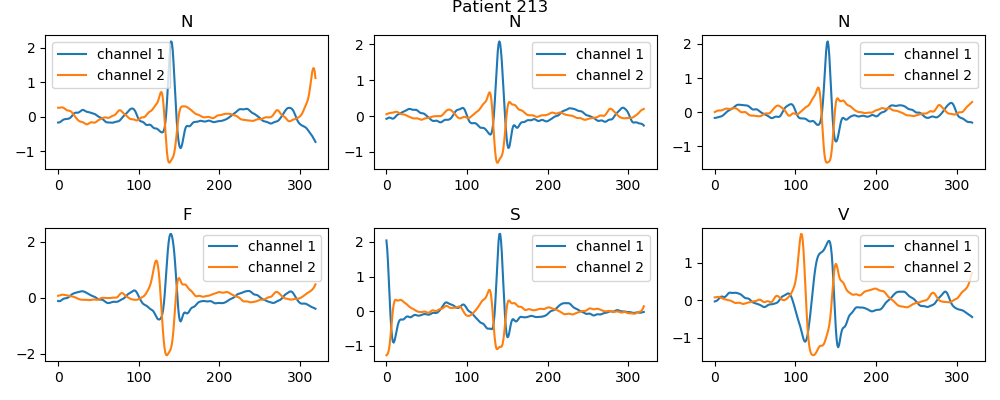

In [10]:
plot_patient(patient_candidates[0])

In [11]:
plot_patient(patient_candidates[1])


(1861, 2, 320)
['S' 'V']


ValueError: Cannot take a larger sample than population when 'replace=False'


(2938, 2, 320)
['V' 'F' 'V' ... 'F' 'V' 'V']


<IPython.core.display.Javascript object>


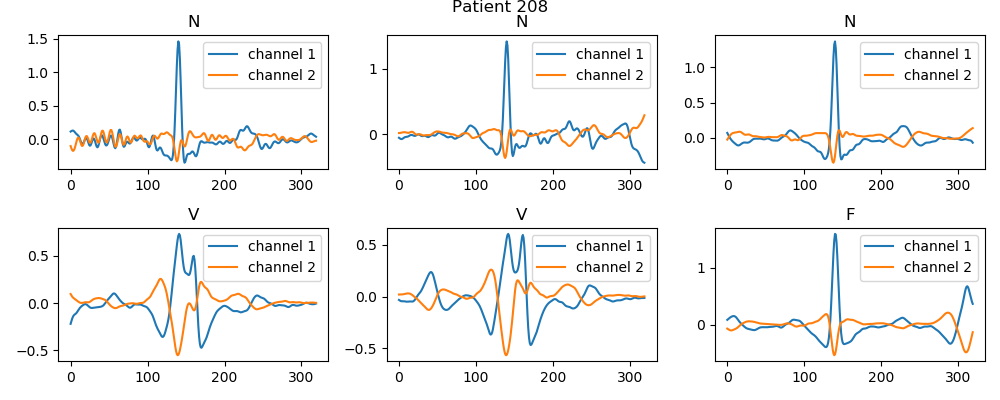

In [12]:
plot_patient(patient_candidates[2])


(2046, 2, 320)
['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S']


<IPython.core.display.Javascript object>


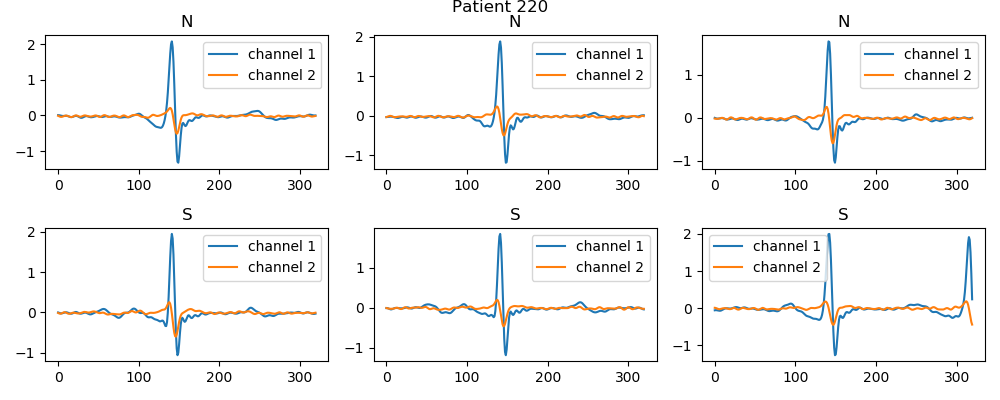

In [13]:
plot_patient(patient_candidates[3])


(2151, 2, 320)
['V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'F' 'V' 'V' 'V' 'S' 'S' 'S' 'S'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'S' 'S' 'V' 'V' 'V' 'S' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V'
 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V' 'V']


<IPython.core.display.Javascript object>


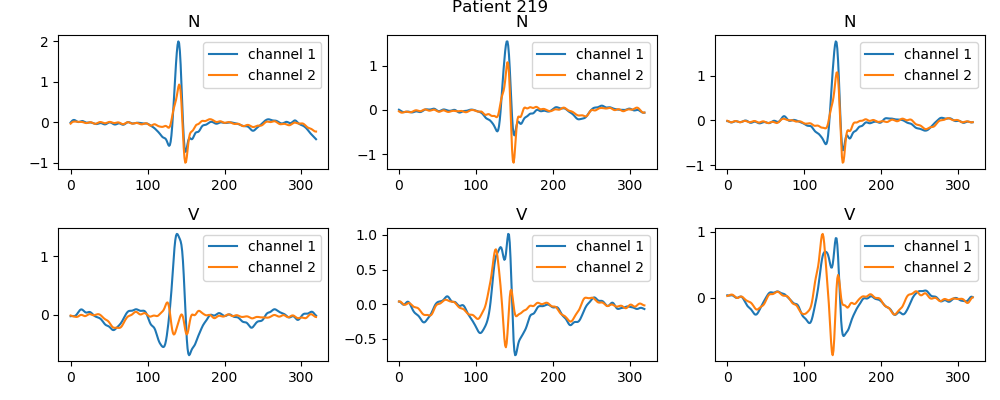

In [14]:
plot_patient(patient_candidates[4])